In [139]:
import pandas as pd
import numpy as np
import math
#import graphlab as gl
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import csv
from sklearn import cross_validation
%matplotlib inline

In [140]:
df=pd.read_csv('data/data.csv')
#df=pd.read_csv('data/CAX_Bidding_TRAIN_Molecule_3_4_5.csv')
#df_test_pre_loe = pd.read_csv('data/CAX_Bidding_TEST_Molecule_6_Pre_LOE.csv')
df['Start_date'] = pd.to_datetime(df['Start_date'])
df['End_date_including_extension'] = pd.to_datetime(df['End_date_including_extension'])
p = df[df['Presentation'] == 'Presentation20']
p[['Winning_price_per_standard_unit', 'Competitor_2nd_Lowest_Price_per_standard_unit']]


,Winning_price_per_standard_unit,Competitor_2nd_Lowest_Price_per_standard_unit
786,19.41545,NaN
787,19.41545,NaN
788,15.92067,NaN
789,19.41000,NaN
790,17.99000,NaN
791,19.40000,NaN
792,19.41500,NaN
793,18.00000,NaN


In [141]:
#cleanup

df = df[(df['Competitor_2nd_Lowest_Price_per_standard_unit'].isnull()) | (df['Winning_price_per_standard_unit'] < df['Competitor_2nd_Lowest_Price_per_standard_unit'])]
df = df[df['ID'] != 680]


In [142]:
p = df[df['Presentation'] == 'Presentation20']
p[['Winning_price_per_standard_unit', 'Competitor_2nd_Lowest_Price_per_standard_unit']]


,Winning_price_per_standard_unit,Competitor_2nd_Lowest_Price_per_standard_unit
786,19.41545,NaN
787,19.41545,NaN
788,15.92067,NaN
789,19.41000,NaN
790,17.99000,NaN
791,19.40000,NaN
792,19.41500,NaN
793,18.00000,NaN


In [143]:
def agg_competitor(data, index_start, index_end, skip):
    copy = data.copy()
    copy['Competitor'] = copy.iloc[:,1].map(lambda x: 0)
    i=index_start
    while i < index_end:
        copy.ix[:,i] = ~copy.ix[:,i].isnull()*1
        copy['Competitor'] = copy.iloc[:,i] + copy['Competitor']
        i=i+skip
    return copy['Competitor']

p_mol_mean_price_pre_loe = {}

def max_price_per_presentation(data):
    return data['Winning_price_per_standard_unit'].max()   
#        p_mol_mean_price_pre_loe['Molecule3'] = data[(data['Molecule'] == 'Molecule3') & (data['Start_date'] <= datetime(2009,3,1,0,0,0))]['Winning_price_per_standard_unit'].max()
#        p_mol_mean_price_pre_loe['Molecule4'] = data[(data['Molecule'] == 'Molecule4') & (data['Start_date'] <= datetime(2011,3,1,0,0,0))]['Winning_price_per_standard_unit'].max()
#        p_mol_mean_price_pre_loe['Molecule5'] = data[(data['Molecule'] == 'Molecule5') & (data['Start_date'] <= datetime(2011,3,1,0,0,0))]['Winning_price_per_standard_unit'].max()
#        p_mol_mean_price_pre_loe['Molecule6'] = data[data['Molecule'] == 'Molecule6']['Winning_price_per_standard_unit'].max()

def days_since_loe(molecule_name, start_date):
    if molecule_name =='Molecule3':
        return float((start_date - datetime(2009,3,1,0,0,0)).days)
    else:
        return float((start_date - datetime(2011,1,1,0,0,0)).days)

def build_presentation_price_dict(data):
    p_presentation_dict  = {}
    print data['Presentation'].unique()
    for item in data['Presentation'].unique():
        row = data.ix[data[data['Presentation'] == item]['Winning_price_per_standard_unit'].idxmax()]
        p_presentation_dict[row['Presentation']] = row['Winning_price_per_standard_unit']
#        if row['Tenure'] > 0:
#            p_presentation_dict[row['Presentation']] = row['Winning_price_per_standard_unit']*row['Tenure']/30
#        else:
#            p_presentation_dict[row['Presentation']] = row['Winning_price_per_standard_unit']
    return p_presentation_dict

def transform_length_of_contract(row):
    value = 0
    if(row['Length_of_contract_in_Months'] < 12):
        value = np.log(row['Length_of_contract_in_Months'])
    return value

def impute_competitor_price(data):
    copy = data.copy()
    copy = copy[(~copy['Competitor_2nd_Lowest_Price_per_standard_unit'].isnull()) & (~copy['Winning_price_per_standard_unit'].isnull())]
    factor_matrix = copy.apply(lambda row: (row['Competitor_2nd_Lowest_Price_per_standard_unit'])/row['Winning_price_per_standard_unit'], axis=1)
    factor = factor_matrix.sum()/factor_matrix.count()
    data['Competitor_2nd_Lowest_Price_per_standard_unit'].fillna(factor*data['Winning_price_per_standard_unit'])
#    print copy['Competitor_2nd_Lowest_Price_per_standard_unit'].sum()
#    print copy['Competitor_2nd_Lowest_Price_per_standard_unit'].count()
#    print copy['Winning_price_per_standard_unit'].sum()
#    print copy['Winning_price_per_standard_unit'].count()
#    print factor_matrix.count()
    

In [144]:
df['Competitor'] = agg_competitor(df, 16, 34, 2)
col=['Molecule','Account','Winning_price_per_standard_unit','Province','Region','Tender_Type', 'Tender_Standard_Unit_per_year', 'Length_of_contract_in_Months', 'Presentation', 'Start_date', 'End_date_including_extension', 'Competitor', 'Competitor_2nd_Lowest_Price_per_standard_unit']
p_presentation_dict_train = build_presentation_price_dict(df)
max_presentation_train = max_price_per_presentation(df)
df2 = df[col]
impute_competitor_price(df2)
df2 = df2.dropna()
df2.loc[:,'Tenure'] = df2.apply(lambda row: days_since_loe(row['Molecule'], row['Start_date'])/30, axis=1)
df2.loc[:,'Presentation'] = df2.apply(lambda row: p_presentation_dict_train[row['Presentation']]/max_presentation_train, axis=1)
df2.loc[:,'Contract_Length'] = df2.apply(lambda row: (row['End_date_including_extension'] - row['Start_date']).days/30 , axis=1)

['Presentation8' 'Presentation9' 'Presentation10' 'Presentation11'
 'Presentation12' 'Presentation13' 'Presentation14' 'Presentation15'
 'Presentation16' 'Presentation17' 'Presentation18' 'Presentation19'
 'Presentation20' 'Presentation21']


In [145]:
df2.loc[:,'Length_of_contract_in_Months'] = df2.apply(lambda row: np.log(row['Length_of_contract_in_Months']), axis=1)
df2.loc[:,'Tender_Standard_Unit_per_year'] = df2.apply(lambda row: np.log(row['Tender_Standard_Unit_per_year']), axis=1)
df2['Extreme_Contract'] = df2.apply(lambda x: transform_length_of_contract(x),axis=1)

In [146]:
p_presentation_dict_train

{'Presentation10': 1.75,
 'Presentation11': 5.6589999999999998,
 'Presentation12': 24.870000000000001,
 'Presentation13': 1.54,
 'Presentation14': 2.7108400000000001,
 'Presentation15': 3.0410699999999999,
 'Presentation16': 1.5203500000000001,
 'Presentation17': 3.0410699999999999,
 'Presentation18': 0.76034999999999997,
 'Presentation19': 1.5203500000000001,
 'Presentation20': 19.41545,
 'Presentation21': 10.49,
 'Presentation8': 4.8700000000000001,
 'Presentation9': 11.269399999999999}

In [147]:
df2=df2[df2['Tenure'] >= 0]
df2=df2.drop(['Molecule', 'Start_date', 'End_date_including_extension', 'Account','Province', 'Tender_Type'],1)



In [148]:
df2 = df2.dropna()

In [149]:
df2.columns

Index([u'Winning_price_per_standard_unit', u'Region',
       u'Tender_Standard_Unit_per_year', u'Length_of_contract_in_Months',
       u'Presentation', u'Competitor',
       u'Competitor_2nd_Lowest_Price_per_standard_unit', u'Tenure',
       u'Contract_Length', u'Extreme_Contract'],
      dtype='object')

In [150]:
df2=pd.get_dummies(df2)
y=df2.as_matrix()[:,0]

In [151]:
df2.head()

,Winning_price_per_standard_unit,Tender_Standard_Unit_per_year,Length_of_contract_in_Months,Presentation,Competitor,Competitor_2nd_Lowest_Price_per_standard_unit,Tenure,Contract_Length,Extreme_Contract,Region_Region1,...,Region_Region19,Region_Region2,Region_Region20,Region_Region3,Region_Region4,Region_Region5,Region_Region6,Region_Region7,Region_Region8,Region_Region9
1,1.56353,10.950210,2.995732,0.195818,5,1.880,10.333333,45,1.097189,0,...,0,0,0,0,0,0,1,0,0,0
2,1.77000,12.263926,3.178054,0.195818,4,1.880,10.333333,30,1.156269,0,...,0,0,0,0,0,0,0,0,0,0
4,1.50000,12.169336,2.484907,0.195818,4,1.730,10.433333,29,0.910235,0,...,0,0,0,0,0,0,0,1,0,0
5,1.45000,11.441880,3.583519,0.195818,4,1.640,10.533333,52,1.276345,1,...,0,0,0,0,0,0,0,0,0,0
6,1.81200,13.816010,2.484907,0.195818,2,1.895,21.833333,18,0.910235,1,...,0,0,0,0,0,0,0,0,0,0


In [152]:
y.shape

(495,)

In [153]:
X=df2.as_matrix()[:,1:]

In [154]:
X.shape

(495, 28)

In [155]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
#          'learning_rate': 0.01, 'loss': 'ls'}

gradient_boosting_grid = {'max_depth': [3, 6, 10],
                     'min_samples_split': [1, 4, 8],
                     'learning_rate': [0.01],
                     'loss': ['ls'],
                     'n_estimators': [100, 300, 500]}

rf_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                            gradient_boosting_grid,
                            n_jobs=-1,
                            verbose=True,
                            scoring='mean_squared_error')
#rf_gridsearch.fit(train_x, train_y)
k_fold = cross_validation.KFold(len(X), 10)
for k, (train, test) in enumerate(k_fold):
    rf_gridsearch.fit(X[train], y[train])
    print("[fold {0}] mse: {1:.5f}, score: {2:.5f}".
          format(k, mean_squared_error(y[test], rf_gridsearch.predict(X[test])), rf_gridsearch.score(X[test], y[test])))

print "best parameters:", rf_gridsearch.best_params_

#best_rf_model = rf_gridsearch.best_estimator_

In [156]:

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

print "mse:", mean_squared_error(y_test, clf.predict(X_test))
print "score:", clf.score(X_test, y_test)

mse: 0.237309962062
score: 0.938065119574



# Fit regression model
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
clf2 = GradientBoostingRegressor(**params)
k_fold = cross_validation.KFold(len(X), 10)
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold):
    clf2.fit(X[train], y[train])
    print("[fold {0}] mse: {1:.5f}, score: {2:.5f}".
          format(k, mean_squared_error(y[test], clf2.predict(X[test])), clf2.score(X[test], y[test])))


In [157]:
#X_train,X_test,y_train,y_test=train_test_split(X,y)

In [158]:


#mse = mean_squared_error(y_test, clf.predict(X_test))
#print("MSE: %.4f" % mse)
#print("MSE: %.4f" % clf.score(X_test, y_test))




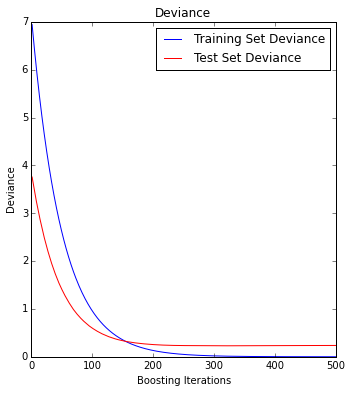

In [159]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [160]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
#plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, df2.feature_importance[sorted_idx])
#plt.xlabel('Relative Importance')
#plt.title('Variable Importance')
#plt.show()

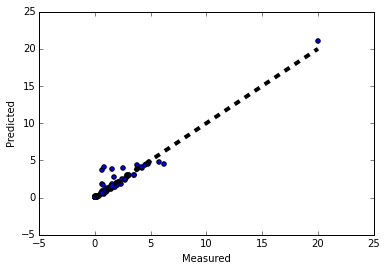

In [161]:
fig, ax = plt.subplots()
ax.scatter(y_test, clf.predict(X_test))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [162]:
reg=linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)
mean_squared_error(y_test,reg.predict(X_test))

0.269334207380377

In [163]:
reg.score(X_test,y_test)

0.92970719904181542

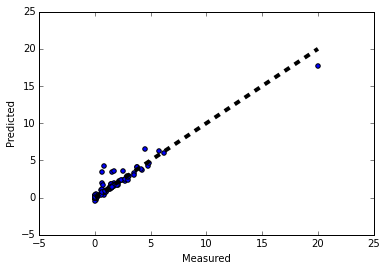

In [164]:
fig, ax = plt.subplots()
ax.scatter(y_test, reg.predict(X_test))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [165]:
y_test[0:10]

array([ 0.12 ,  1.48 ,  0.044,  0.58 ,  0.025,  0.84 ,  0.8  ,  1.65 ,
        0.053,  1.11 ])

In [166]:
y_pred[0:10]

array([ 0.11582706,  1.5783218 ,  0.04798537,  0.67355839,  0.0497459 ,
        0.48753391,  0.9002276 ,  1.51179103,  0.07512887,  0.86491316])

In [219]:
def apply_default_on_test(row):
    if pd.isnull(row['Competitor_2nd_Lowest_Price_per_standard_unit']):
        return p_presentation_dict_train[row['Presentation']]*.9
    return row['Competitor_2nd_Lowest_Price_per_standard_unit']
        

In [220]:
df_test=pd.read_csv('data/CAX_Bidding_TEST_Molecule_6_Post_LOE.csv')
df_test['Start_date']=pd.to_datetime(df_test['Start_date'])
df_test['End_date_including_extension']=pd.to_datetime(df_test['End_date_including_extension'])

In [221]:
df_test['Competitor'] = agg_competitor(df_test, 16, 34, 2)
col=['Molecule','Account','Province','Region','Tender_Type', 'Tender_Standard_Unit_per_year', 'Length_of_contract_in_Months', 'Presentation', 'Start_date', 'End_date_including_extension', 'Competitor','Competitor_2nd_Lowest_Price_per_standard_unit']
df_test = df_test[col]
df_test.loc[:,'Tenure'] = df_test.apply(lambda row: (days_since_loe(row['Molecule'], row['Start_date']))/30, axis=1)
df_test.loc[:,'Contract_Length'] = df_test.apply(lambda row: (row['End_date_including_extension'] - row['Start_date']).days/30 , axis=1)
df_test['Competitor_2nd_Lowest_Price_per_standard_unit'] = df_test.apply(lambda row: apply_default_on_test(row), axis=1)
df_test.loc[:,'Presentation'] = df_test.apply(lambda row: p_presentation_dict_train[row['Presentation']]/max_presentation_train, axis=1)
#p_test_presentation_dict_train = build_presentation_price_dict(df_test)
#max_presentation_train = max_price_per_presentation(df_test)
#df_test.loc[:,'Length_of_contract_in_Months'] = df_test.apply(lambda row: row['Length_of_contract_in_Months'], axis=1)
df_test['Extreme_Contract'] = df_test.apply(lambda x: transform_length_of_contract(x),axis=1)
df_test.loc[:,'Length_of_contract_in_Months'] = df_test.apply(lambda row: np.log(row['Length_of_contract_in_Months']), axis=1)
df_test.loc[:,'Tender_Standard_Unit_per_year'] = df_test.apply(lambda row: np.log(row['Tender_Standard_Unit_per_year']), axis=1)
#df_test['Competitor_2nd_Lowest_Price_per_standard_unit'] = df_test['Competitor_2nd_Lowest_Price_per_standard_unit'].fillna(df_test['Competitor_2nd_Lowest_Price_per_standard_unit'].mean())


In [222]:
df_test.columns

Index([u'Molecule', u'Account', u'Province', u'Region', u'Tender_Type',
       u'Tender_Standard_Unit_per_year', u'Length_of_contract_in_Months',
       u'Presentation', u'Start_date', u'End_date_including_extension',
       u'Competitor', u'Competitor_2nd_Lowest_Price_per_standard_unit',
       u'Tenure', u'Contract_Length', u'Extreme_Contract'],
      dtype='object')

In [223]:
#df_pres=pd.read_csv('data/CAX_Bidding_TEST_Molecule_6_Pre_LOE.csv')
#col_pres =['Molecule', 'Region','Winning_price_per_standard_unit', 'Length_of_contract_in_Months', 'Presentation', 'Start_date']

#df_pres = df_pres[col_pres]
#df_pres['Tenure'] = df_pres.iloc[:,1].map(lambda x: -1)

#p_test_presentation_dict = build_presentation_price_dict(df_pres)
#max_test_presentation = max_price_per_presentation(df_pres)


In [224]:
#p_test_presentation_dict

In [225]:
#df_test.loc[:,'Presentation'] = df_test.apply(lambda row: np.log(p_test_presentation_dict[row['Presentation']]/max_test_presentation), axis=1)

In [226]:
df_test.columns

Index([u'Molecule', u'Account', u'Province', u'Region', u'Tender_Type',
       u'Tender_Standard_Unit_per_year', u'Length_of_contract_in_Months',
       u'Presentation', u'Start_date', u'End_date_including_extension',
       u'Competitor', u'Competitor_2nd_Lowest_Price_per_standard_unit',
       u'Tenure', u'Contract_Length', u'Extreme_Contract'],
      dtype='object')

In [227]:
df_test=df_test.drop(['Molecule', 'Start_date', 'End_date_including_extension', 'Account', 'Province', 'Tender_Type'],1)

In [228]:
df_test.columns

Index([u'Region', u'Tender_Standard_Unit_per_year',
       u'Length_of_contract_in_Months', u'Presentation', u'Competitor',
       u'Competitor_2nd_Lowest_Price_per_standard_unit', u'Tenure',
       u'Contract_Length', u'Extreme_Contract'],
      dtype='object')

In [229]:
df_test=pd.get_dummies(df_test)
df_test


,Tender_Standard_Unit_per_year,Length_of_contract_in_Months,Presentation,Competitor,Competitor_2nd_Lowest_Price_per_standard_unit,Tenure,Contract_Length,Extreme_Contract,Region_Region1,Region_Region10,...,Region_Region19,Region_Region2,Region_Region20,Region_Region3,Region_Region4,Region_Region5,Region_Region6,Region_Region7,Region_Region8,Region_Region9
0,10.268131,1.386294,0.780678,0,17.473905,0.066667,5,1.386294,0,0,...,0,1,0,0,0,0,0,0,0,0
1,8.779557,3.583519,0.780678,0,17.473905,0.066667,42,0.000000,0,0,...,0,0,0,1,0,0,0,0,0,0
2,10.596635,2.708050,0.780678,1,11.989000,3.700000,15,0.000000,0,0,...,0,0,1,0,0,0,0,0,0,0
3,9.595535,2.079442,0.780678,1,10.985000,0.133333,12,2.079442,0,0,...,0,1,0,0,0,0,0,0,0,0
4,10.340451,2.302585,0.780678,2,10.985000,0.133333,17,2.302585,0,0,...,0,0,0,0,0,0,0,0,0,1
5,10.533695,1.386294,0.780678,2,12.490000,0.133333,7,1.386294,0,0,...,0,1,0,0,0,0,0,0,0,0
6,9.200290,3.583519,0.780678,0,17.473905,0.133333,52,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
7,3.610918,3.465736,0.780678,2,11.000000,0.133333,42,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
8,9.047821,3.871201,0.780678,2,11.290000,4.566667,15,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9.015298,3.555348,0.780678,2,9.250000,5.000000,35,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
x_test_mtx=df_test.as_matrix()

In [231]:
y_test_pred = clf.predict(x_test_mtx)

In [232]:
#y_test_pred

In [233]:
for elem in y_test_pred:
    print elem

20.9500190681
14.8202919433
8.66731537631
8.67658678756
8.6739376677
10.8834715126
20.4729974952
8.09494702859
8.620803001
8.06176098541
22.5889185408
8.67269675286
8.15714120918
8.49073715283
20.4231221424
20.8629249471
8.66342534161
4.83591506545
7.99628620187
20.9172144262
4.80241869985
8.49632917871
19.9681986542
7.99628620187
4.54112245948
4.54112245948
20.877679887
4.54138683073
4.79277995279
4.53376128819
7.63280248786
7.63389403219
4.52424173735
4.54262774557
4.54990737638
3.0275846545
7.70066728792
4.51696210654
4.51595841378
7.38803143249
3.03063376982
4.54138683073
3.02728184356
3.85362671083
4.39967705743
20.8789248266
4.54178684884
4.24971173799
20.6248805958
4.51663366864
4.54354125729
4.3979456882
3.83781071083
3.82901792644
20.597038469
4.51949430797
20.2553774707
2.99292705507
2.97908776518
2.99879118418
3.83139917311
3.02454033477
3.02454033477
3.00164527186
4.44259590116
4.44176356992
2.94941715438
7.40710402738
2.9872270363
2.974955076
3.00460744844
2.96269008685
3.

In [234]:
y_test_pred_reg = reg.predict(x_test_mtx)
zipped = zip(y_test_pred_reg, y_test_pred)

In [235]:
for elem in y_test_pred_reg:
    print elem

14.1013754203
16.8088064255
12.1110874624
7.65617758709
7.62946419214
9.70668872759
17.2141497908
11.3886456333
12.0458699014
9.98007512662
17.6222337635
7.33865573852
11.9698823422
7.83856900427
16.601792034
16.7835041109
7.54296567677
7.71927494211
9.81988680431
13.5347207138
4.82339093705
9.77334220151
17.1797690137
9.77376348295
7.92206520655
7.90000961679
16.8272810498
6.23533332521
6.68122365648
7.67880964695
9.66119483748
8.70932928381
7.46681139038
6.78733107147
6.76851926829
7.29499012144
8.21415421821
7.28765452999
6.36882689216
9.81396568572
6.40533908489
6.09374647475
4.9394838152
5.59801219822
6.28434477173
16.5682064066
5.6001322364
5.99145523177
17.3078964251
7.06016113174
5.63916257144
6.72486213728
5.66678021167
5.25492362931
17.3535578876
7.59171681412
13.6903873655
5.20731073202
4.47165014107
5.31298297215
5.33865909022
4.96917276555
4.74241312713
4.76525458119
6.73840542398
5.69771422864
4.64887466433
8.83647356727
1.26565815942
4.6229478105
4.35991331442
3.93334989